In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# import Library

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, linear_model, metrics
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Readind Data and Processing Data

In [ ]:
dtypes = {'id':'int64', 'item_nbr':'int32', 'store_nbr':'int8', 'onpromotion':str}
data = {
    'tra': pd.read_csv('/content/drive/My Drive/extracted/train.csv', dtype=dtypes, parse_dates=['date']),
    'tes': pd.read_csv('/content/drive/My Drive/extracted/test.csv', dtype=dtypes, parse_dates=['date']),
    'ite': pd.read_csv('/content/drive/My Drive/extracted/items.csv'),
    'sto': pd.read_csv('/content/drive/My Drive/extracted/stores.csv'),
    'trn': pd.read_csv('/content/drive/My Drive/extracted/transactions.csv', parse_dates=['date']),
    'hol': pd.read_csv('/content/drive/My Drive/extracted/holidays_events.csv', dtype={'transferred':str}, parse_dates=['date']),
    'oil': pd.read_csv('/content/drive/My Drive/extracted/oil.csv', parse_dates=['date']),
    }

In [ ]:
train = data['tra'][(data['tra']['date'].dt.month == 8) & (data['tra']['date'].dt.day > 15)]
test = data['tes'][(data['tes']['date'].dt.month == 8) & (data['tes']['date'].dt.day > 15)]
strain = train.sample(frac =.5) 
stest = test.sample(frac =.5)
print(strain.shape,stest.shape)

(2229506, 6) (1685232, 5)


In [ ]:
target = strain['unit_sales'].values
target[target < 0.] = 0.
strain['unit_sales'] = target

In [ ]:
strain = pd.merge(strain, data['ite'], how='left', on=['item_nbr'])
strain = pd.merge(strain, data['sto'], how='left', on=['store_nbr'])
data_h_1 = data['hol'][data['hol']['locale'] == 'National'][['date','transferred']]
data_h_1['transferred'] = data_h_1['transferred'].map({'False': 0, 'True': 1})
strain = pd.merge(strain, data_h_1, how='left', on=['date'])
strain = pd.merge(strain, data['oil'], how='left', on=['date'])

stest = pd.merge(stest, data['ite'], how='left', on=['item_nbr'])
stest = pd.merge(stest, data['sto'], how='left', on=['store_nbr'])
data_h_t = data['hol'][data['hol']['locale'] == 'National'][['date','transferred']]
data_h_t['transferred'] = data_h_t['transferred'].map({'False': 0, 'True': 1})
stest = pd.merge(stest, data_h_t, how='left', on=['date'])
stest = pd.merge(stest, data['oil'], how='left', on=['date'])

In [ ]:
from sklearn import preprocessing
def df_transform(df):
    df['date'] = pd.to_datetime(df['date'])
    df['yea'] = df['date'].dt.year
    df['mon'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['onpromotion'] = df['onpromotion'].map({'False': 1, 'True': 2})
    df['perishable'] = df['perishable'].map({0:1.0, 1:1.25})
    df = df.fillna(0)
    return df
def df_lbl_enc(df):
    for c in df.columns:
        if df[c].dtype == 'object':
            lbl = preprocessing.LabelEncoder()
            df[c] = lbl.fit_transform(df[c])
            print(c)
    return df

In [ ]:
strain_t = df_transform(strain)
strain_t_e = df_lbl_enc(strain_t)

stest_t = df_transform(stest)
stest_t_e = df_lbl_enc(stest_t)

family
city
state
type
family
city
state
type


In [ ]:
strain_t_e_dateIndex = strain_t_e.set_index('date')
stest_t_e_dateIndex = stest_t_e.set_index('date')

In [ ]:
col =[c for c in strain_t_e_dateIndex if c not in ['id','item_nbr','mon','class','city','cluster','unit_sales']]
print(col)
train_features = strain_t_e_dateIndex[col]
target = np.log1p(strain_t_e_dateIndex[['unit_sales']])

col =[c for c in stest_t_e_dateIndex if c not in ['id','item_nbr','mon','class','city','cluster']]
features = stest_t_e_dateIndex[col]

['store_nbr', 'onpromotion', 'family', 'perishable', 'state', 'type', 'transferred', 'dcoilwtico', 'yea', 'day', 'dayofweek']


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, target, test_size=0.20, random_state=42)

In [ ]:
W_train = X_train['perishable']#.map({0:1.0, 1:1.25})
W_test = X_test['perishable']

# Random Forest Regression

In [ ]:
rf = RandomForestRegressor(max_features = "auto", random_state =50 )


In [ ]:
rf.fit(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=50, verbose=0, warm_start=False)

In [ ]:
print ('RF accuracy: TRAINING', rf.score(X_train,y_train,W_train))
print ('RF accuracy: TESTING', rf.score(X_test,y_test,W_test))
print("feature Importance",rf.feature_importances_)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
result = seasonal_decompose(np.log1p(strain_t_e.unit_sales.values),freq=12)
trace1=go.Scatter(x=pd.to_datetime(strain_t_e.date),y=result.trend,name="trend")
trace2 = go.Scatter(
    x = pd.to_datetime(strain_t_e.date),y = result.seasonal,
    name = 'Seasonal'
)
dat=[trace1,trace2]
plot(dat)
plt.plot(result.trend)
plt.plot(result.seasonal)

In [ ]:
result = seasonal_decompose(np.log1p(strain_t_e.unit_sales.values),freq=6)
trace1=go.Scatter(x=pd.to_datetime(strain_t_e.date),y=result.trend,name="trend")
trace2 = go.Scatter(
    x = pd.to_datetime(strain_t_e.date),y = result.seasonal,
    name = 'Seasonal'
)
dat=[trace1,trace2]
plot(dat)
plt.plot(result.trend)
plt.plot(result.seasonal)

# Polynomial regression


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=3)
x_train_poly = polynomial_features.fit_transform(X_train)
x_test_poly = polynomial_features.fit_transform(X_test)

In [ ]:
from sklearn.linear_model import LinearRegression 
model = LinearRegression()
model.fit(x_train_poly, y_train)
y_test_pred=model.predict(x_test_poly)
y_train_pred=model.predict(x_train_poly)


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
print("rmse value of linear regression using sklearn = ",np.sqrt(np.mean((y_test-y_test_pred)**2)))
sse=np.sum((y_test-y_test_pred)**2)
print("sum of squared error value =",sse)
r2=r2_score(y_test,y_test_pred)
print("r2_score",r2)

# Displaying trend and Seasonality

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = strain_t_e.unit_sales.values
result = seasonal_decompose(series, model='additive',freq=12,two_sided = False)
plt.plot(result.trend)



In [ ]:
plt.plot(result.seasonal)

In [ ]:
strain_t_e_dateIndex['unit_sales'].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Date', fontsize=20);

# Printing Trend Using Rolling Average

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


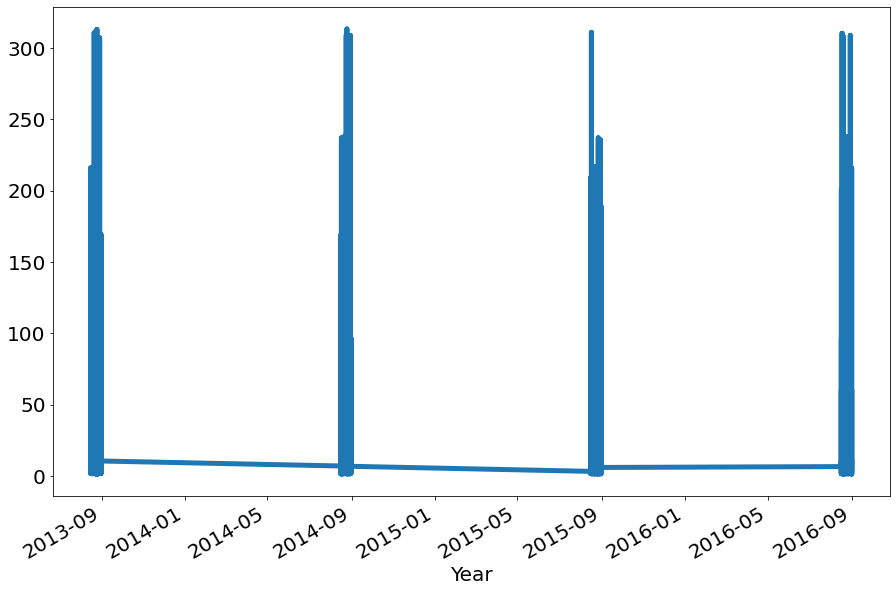

In [ ]:
strain_t_e_dateIndex['unit_sales'].rolling(12).mean().plot(x=strain_t_e_dateIndex['yea'],figsize=(15,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);


In [ ]:
rolling_mean = strain_t_e_dateIndex.rolling(window = 12).mean()
rolling_std = strain_t_e_dateIndex.rolling(window = 12).std()

In [ ]:
rolling_mean.shape()

In [ ]:
plt.rcParams['agg.path.chunksize'] = 10000000000000000000000
plt.plot(strain_t_e_dateIndex, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [ ]:
result = adfuller(strain_t_e_dateIndex['unit_sales'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

# Auto Regressive model

In [ ]:
from statsmodels.tsa.ar_model import AR
model = AR(X_train)
model_fitted = model.fit()

In [ ]:
print('The lag value chose is: %s' % model_fitted.k_ar)
print('The coefficients of the model are:\n %s' % model_fitted.params)

In [ ]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

 # Navie bias

In [ ]:
stest_t_e_dateIndex.head()

,id,store_nbr,item_nbr,onpromotion,family,class,perishable,city,state,type,cluster,transferred,dcoilwtico,yea,mon,day,dayofweek
date,,,,,,,,,,,,,,,,,
2017-08-19,126305934,46,1038950,1,5,2712,1.25,18,12,0,14,0.0,0.00,2017,8,19,5
2017-08-23,127142442,44,1946325,1,12,1026,1.00,18,12,0,5,0.0,48.45,2017,8,23,2
2017-08-29,128343097,28,1412379,1,13,1236,1.00,8,6,4,10,0.0,46.46,2017,8,29,1
2017-08-28,128141244,30,1971730,1,15,6242,1.00,8,6,2,3,0.0,46.40,2017,8,28,0
2017-08-25,127423805,8,2026858,2,12,1034,1.00,18,12,3,8,0.0,47.65,2017,8,25,4


In [ ]:
dd= np.asarray(strain_t_e_dateIndex.unit_sales)
y_hat =stest_t_e_dateIndex.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(strain_t_e_dateIndex.index, strain_t_e_dateIndex['unit_sales'], label='Train')
plt.plot(stest_t_e_dateIndex.index,stest_t_e_dateIndex['unit_sales'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

# ARIMA model


In [ ]:
df_log = np.log(strain_t_e_dateIndex)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


,id,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,state,type,cluster,transferred,dcoilwtico,yea,mon,day,dayofweek
date,,,,,,,,,,,,,,,,,,
2014-08-24,17.203095,3.663562,14.030465,2.079442,0.0,1.945910,7.680637,0.223144,1.098612,-inf,0.000000,1.791759,-inf,-inf,7.607878,2.079442,3.178054,1.791759
2013-08-27,16.145275,1.098612,13.038556,0.693147,-inf,2.397895,6.990257,0.000000,2.890372,2.484907,1.098612,2.079442,-inf,4.692357,7.607381,2.079442,3.295837,0.000000
2013-08-18,16.108216,3.850148,12.904640,2.708050,-inf,2.397895,6.999422,0.000000,2.890372,2.484907,-inf,2.639057,-inf,-inf,7.607381,2.079442,2.890372,1.791759
2014-08-27,17.207557,2.079442,13.277528,2.457193,0.0,3.135494,7.741534,0.223144,2.890372,2.484907,1.098612,2.079442,-inf,4.562471,7.607878,2.079442,3.295837,0.693147
2013-08-30,16.159747,3.178054,12.788933,3.784190,-inf,1.791759,8.018955,0.000000,2.079442,1.791759,1.098612,0.000000,-inf,4.681946,7.607381,2.079442,3.401197,1.386294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-24,18.303537,3.258097,13.034467,1.694330,0.0,3.295837,7.789869,0.223144,2.079442,1.791759,1.098612,2.302585,-inf,3.834926,7.608871,2.079442,3.178054,0.693147
2013-08-16,16.097206,3.465736,13.034467,1.837848,-inf,3.295837,7.789869,0.223144,2.079442,1.791759,0.693147,1.098612,-inf,4.678235,7.607381,2.079442,2.772589,1.386294
2014-08-22,17.199123,3.496508,13.055982,2.197225,0.0,2.397895,6.981006,0.000000,2.833213,2.197225,0.693147,1.098612,-inf,4.539137,7.607878,2.079442,3.091042,1.386294


In [ ]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(results.fittedvalues, color='red')